# Kaggle Competition - FAVOUR ELEDU_FULL

################################################## FULL ##################################################

# Libraries

#### 1. External libraries

In [1]:
import sys
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
from pandas                 import DataFrame
from pandas                 import read_csv
from pandas                 import Series
from numpy                  import array
from numpy                  import random
from matplotlib             import pyplot
import warnings
from pandas               import get_dummies
from numpy                import where
from numpy                import nan
from scipy.stats.mstats   import winsorize

warnings.filterwarnings("ignore")

from scipy.stats.mstats import winsorize
from scipy.stats          import pearsonr
import warnings
from sklearn import linear_model
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from itertools import combinations

#### 2. Local libraries

In [2]:
from ieseg import partition
from ieseg import roc

## Import data

#### 1. Read CSV

In [3]:
# Reading the given CSV files and storing them in the required variables

train_set =read_csv("./Data/orange_churn_train.csv",sep=",")
test_set  =read_csv("./Data/orange_churn_test.csv",sep=",")

#### 2. Inspect data

In [4]:
## training set ##
train_set.head(2)

,cust_id,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,churn
0,3,NaN,NaN,NaN,NaN,NaN,1351.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,7P5s,ZI9m,NoEd,mj86,NaN,0
1,4,NaN,NaN,NaN,NaN,NaN,644.0,0.0,NaN,NaN,...,76DJixu,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN,0


In [5]:
## test set ##
test_set.head(2)

,cust_id,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,1,NaN,NaN,NaN,NaN,NaN,224.0,0.0,NaN,NaN,...,oslk,4EXRt2K,LM8l689qOp,NaN,NaN,rgKb,RAYp,F2FyR07IdsN7I,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,7511.0,7.0,NaN,NaN,...,oslk,OMtCHhK,LM8l689qOp,NaN,kG3k,FSa2,RAYp,55YFVY9,mj86,NaN


#### 3. Count the number of churners

In [6]:
## train set ## 
train_set[["cust_id","churn"]].groupby(["churn"]).count()

## NB: No Churners list in the test set

,cust_id
churn,
0,9264
1,736


## Pre-processing

Key Outcomes:




- Now working with other variables in the dataset                                                                                         
- Re-Work the Numerical variables and pick best variables with PCA

In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 232 entries, cust_id to churn
dtypes: float64(191), int64(3), object(38)
memory usage: 17.7+ MB


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 231 entries, cust_id to Var230
dtypes: float64(191), int64(2), object(38)
memory usage: 17.6+ MB


In [9]:
train_set.dtypes

cust_id      int64
Var1       float64
Var2       float64
Var3       float64
Var4       float64
            ...   
Var227      object
Var228      object
Var229      object
Var230     float64
churn        int64
Length: 232, dtype: object

In [10]:
test_set['Var29'].nunique()

2

#### Drop columns with 1 unique value (constant values)

In [11]:
# # Count number of unique values of each variable
# vars_nunique = train_set.apply(pd.Series.nunique, dropna=False, axis=0)

# cont_vars = vars_nunique.index[vars_nunique < 2].tolist()

# print("Drop constant variable:", cont_vars)

# # Correct variable list
# list_ = [v for v in train_set.columns if v not in cont_vars]
# list_test = [v for v in test_set.columns if v not in cont_vars]

# # Update train, test set
# train_set = train_set[list_]
# test_set = test_set[list_test]

In [12]:
############# initial method ##############

In [13]:
drop_cols = [c for c
             in list(train_set)
             if train_set[c].nunique() < 2]
train_set = train_set.drop(columns=drop_cols)

In [14]:
train_set.nunique()

cust_id    10000
Var1           9
Var3          46
Var4           2
Var5          99
           ...  
Var226        23
Var227         7
Var228        27
Var229         4
churn          2
Length: 207, dtype: int64

In [15]:
drop_cols = [c for c
             in list(test_set)
             if test_set[c].nunique() < 2]
test_set = test_set.drop(columns=drop_cols)

#### Selecting Variables with at least < 100% null values

In [16]:
# REMOVING COLUMNS WITH 95% NULL VALUES

a = train_set.isna().sum()/len(train_set)*100
variables = train_set.columns
variable = [ ]
for i in range(len(variables)):
    if a[i] >= 95:   #setting the threshold as 90%
        variable.append(variables[i])
#variable
nulldf = train_set[variable]
train_set = train_set.drop(columns = variable)

In [17]:
train_set

,cust_id,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,...,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229,churn
0,3,1351.0,7.0,120.0,64.0,80.0,10.0,24.0,200.00,0.0,...,4UxGlow,zCkv,catzS2D,LM8l689qOp,ELof,7P5s,ZI9m,NoEd,mj86,0
1,4,644.0,0.0,0.0,148.0,185.0,0.0,40.0,186.64,0.0,...,7OmVzos,oslk,76DJixu,LM8l689qOp,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,0
2,7,2583.0,0.0,0.0,984.0,1230.0,42.0,152.0,356.64,5.0,...,meWR98m,oslk,I5dzv5f,LM8l689qOp,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,1
3,8,1463.0,7.0,5068.0,276.0,345.0,12.0,288.0,166.56,0.0,...,ie2oOXS,oslk,xwyAw04,LM8l689qOp,kG3k,fKCe,RAYp,F2FyR07IdsN7I,mj86,0
4,9,77.0,0.0,0.0,24.0,30.0,0.0,8.0,278.96,5.0,...,7OmVzos,oslk,76DJixu,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19993,1281.0,14.0,5912.0,124.0,155.0,0.0,0.0,200.00,0.0,...,Qtov48t,oslk,B87Rt2K,jySVZNlOJy,kG3k,FSa2,RAYp,55YFVY9,mj86,0
9996,19995,987.0,14.0,3880.0,144.0,180.0,2.0,104.0,607.92,0.0,...,fxJmel6,oslk,WfsWw2A,LM8l689qOp,kG3k,453m,ZI9m,iyHGyLCEkQ,NaN,0
9997,19996,1057.0,14.0,544.0,68.0,85.0,4.0,64.0,176.56,0.0,...,KPaRa8C,oslk,l_freV4,LM8l689qOp,kG3k,7P5s,RAYp,F2FyR07IdsN7I,am7c,0
9998,19997,721.0,7.0,0.0,136.0,170.0,0.0,72.0,220.08,0.0,...,x_lA5lA,oslk,3B1mC_N,NaN,NaN,453m,RAYp,F2FyR07IdsN7I,NaN,1


In [18]:
for_test = train_set.iloc[:,0:78].columns
test_set = test_set[for_test]

In [19]:
test_set

,cust_id,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
0,1,224.0,0.0,0.0,136.0,170.0,2.0,24.0,314.16,0.0,...,FzaX,snhYH7D,oslk,4EXRt2K,LM8l689qOp,NaN,rgKb,RAYp,F2FyR07IdsN7I,NaN
1,2,7511.0,7.0,44.0,3104.0,3880.0,22.0,3656.0,253.52,0.0,...,FzaX,_lwmIK9,oslk,OMtCHhK,LM8l689qOp,kG3k,FSa2,RAYp,55YFVY9,mj86
2,5,70.0,0.0,0.0,104.0,130.0,0.0,32.0,429.60,0.0,...,FzaX,5KqzVUs,oslk,nCi34g5,LM8l689qOp,NaN,me1d,RAYp,F2FyR07IdsN7I,NaN
3,6,2863.0,7.0,72.0,324.0,405.0,6.0,192.0,166.56,5.0,...,FzaX,FB4YlW4,oslk,0p8OTZB,jySVZNlOJy,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN
4,10,770.0,7.0,160.0,140.0,175.0,4.0,120.0,326.16,0.0,...,FzaX,WWmfR8o,oslk,c4R2fT4,LM8l689qOp,ELof,TNEC,RAYp,F2FyR07IdsN7I,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19989,693.0,0.0,0.0,44.0,55.0,4.0,0.0,220.08,0.0,...,FzaX,yO76hzI,oslk,O98EKx8,LM8l689qOp,NaN,Qcbd,RAYp,F2FyR07IdsN7I,NaN
9996,19992,1652.0,7.0,1888.0,308.0,385.0,8.0,296.0,133.12,0.0,...,FzaX,4UxGlow,QKW8DRm,catzS2D,LM8l689qOp,ELof,Xa3G,ZI9m,NoEd,am7c
9997,19994,1925.0,0.0,0.0,312.0,390.0,8.0,264.0,200.00,0.0,...,FqMWi1g,A7V8iqZ,oslk,C7Jqqb8,bCPvVye,kG3k,Aoh3,RAYp,F2FyR07IdsN7I,mj86
9998,19998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,FzaX,NlJA1m8,oslk,rUjzgmc,LM8l689qOp,NaN,rgKb,RAYp,F2FyR07IdsN7I,NaN


#### 1. Selecting only categorical variables

In [20]:
train_DT = train_set.select_dtypes(object)
train_DT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Var192  9940 non-null   object
 1   Var193  10000 non-null  object
 2   Var194  2573 non-null   object
 3   Var195  10000 non-null  object
 4   Var196  10000 non-null  object
 5   Var197  9972 non-null   object
 6   Var198  10000 non-null  object
 7   Var199  9999 non-null   object
 8   Var200  4951 non-null   object
 9   Var201  2572 non-null   object
 10  Var202  10000 non-null  object
 11  Var203  9972 non-null   object
 12  Var204  10000 non-null  object
 13  Var205  9617 non-null   object
 14  Var206  8913 non-null   object
 15  Var207  10000 non-null  object
 16  Var208  9972 non-null   object
 17  Var210  10000 non-null  object
 18  Var211  10000 non-null  object
 19  Var212  10000 non-null  object
 20  Var214  4951 non-null   object
 21  Var216  10000 non-null  object
 22  Var217  9862 non-null  

In [21]:
# for the test set
test_char = test_set.select_dtypes(object)
test_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Var192  9925 non-null   object
 1   Var193  10000 non-null  object
 2   Var194  2558 non-null   object
 3   Var195  10000 non-null  object
 4   Var196  10000 non-null  object
 5   Var197  9972 non-null   object
 6   Var198  10000 non-null  object
 7   Var199  9999 non-null   object
 8   Var200  4927 non-null   object
 9   Var201  2558 non-null   object
 10  Var202  10000 non-null  object
 11  Var203  9972 non-null   object
 12  Var204  10000 non-null  object
 13  Var205  9613 non-null   object
 14  Var206  8947 non-null   object
 15  Var207  10000 non-null  object
 16  Var208  9972 non-null   object
 17  Var210  10000 non-null  object
 18  Var211  10000 non-null  object
 19  Var212  10000 non-null  object
 20  Var214  4927 non-null   object
 21  Var216  10000 non-null  object
 22  Var217  9861 non-null  

In [22]:
train_DT.head()

,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
0,52Iq9ayE15,TW8dXluYzKpktZjuY8kSPBaZa,NaN,taul,1K8T,z32l,fhk21Ss,o0q8tiE,04tGuNR,NaN,...,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,ELof,7P5s,ZI9m,NoEd,mj86
1,uGLq9ayE15,RO12,NaN,taul,1K8T,_8YK,8ij6Lg8,nQUveAzAF7,NaN,NaN,...,FzaX,7OmVzos,oslk,76DJixu,LM8l689qOp,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN
2,BQa9tYsdof,RO12,NaN,taul,1K8T,0Xwj,DXsZJjN,VxuoaY5mnT,NaN,NaN,...,FzaX,meWR98m,oslk,I5dzv5f,LM8l689qOp,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN
3,CEat0G8rTN,RO12,SEuy,taul,1K8T,wOc1,xniu5tB,r83_sZi,56KNwa_,smXZ,...,FzaX,ie2oOXS,oslk,xwyAw04,LM8l689qOp,kG3k,fKCe,RAYp,F2FyR07IdsN7I,mj86
4,xddq9ayfAo,RO12,NaN,taul,1K8T,z32l,8ij6Lg8,r83_sZi,NaN,NaN,...,NaN,7OmVzos,oslk,76DJixu,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN


In [23]:
# extract the data_types
train_types =  train_DT.dtypes.to_dict()

In [24]:
# for the test set
# extract the data_types
test_types =  test_char.dtypes.to_dict()

In [25]:
# train_DT_ = (train_DT.groupby('Var192').size()) / len(train_DT)
# train_DT['Var192_encode'] = train_DT['Var192'].apply(lambda x : train_DT_[x])

#### 1.1 Handling Missing Values in the Categorical Variables and Re-encoding

* the following applies for the string variables:

    1. NANs are replaced with "missing", creating a new category in all columns with NANs.
    2. Frequency encoding applied and previous columns dropped. New variables encoded with prefix "fe_"

In [26]:
# Categorical variable for further evaluation of the character data types

def treatCategorical (variable: str, inDataSet: DataFrame) -> DataFrame:
    inDataSet[variable] = inDataSet[variable].replace({nan: "missing"})
    freq_inDataSet      = (inDataSet.groupby(inDataSet[variable]).size()) / len(inDataSet)
    inDataSet["fe_%s" %variable]= inDataSet[variable].apply(lambda x : freq_inDataSet[x])
    inDataSet           = inDataSet.drop(columns=[variable])
    return inDataSet

In [27]:
# train
for column in train_DT.columns:
    columnType = train_types[column]
    print(f"{column} : {columnType}")
    train_DT = treatCategorical(variable = column, inDataSet = train_DT)

Var192 : object
Var193 : object
Var194 : object
Var195 : object
Var196 : object
Var197 : object
Var198 : object
Var199 : object
Var200 : object
Var201 : object
Var202 : object
Var203 : object
Var204 : object
Var205 : object
Var206 : object
Var207 : object
Var208 : object
Var210 : object
Var211 : object
Var212 : object
Var214 : object
Var216 : object
Var217 : object
Var218 : object
Var219 : object
Var220 : object
Var221 : object
Var222 : object
Var223 : object
Var225 : object
Var226 : object
Var227 : object
Var228 : object
Var229 : object


In [28]:
train_DT

,fe_Var192,fe_Var193,fe_Var194,fe_Var195,fe_Var196,fe_Var197,fe_Var198,fe_Var199,fe_Var200,fe_Var201,...,fe_Var219,fe_Var220,fe_Var221,fe_Var222,fe_Var223,fe_Var225,fe_Var226,fe_Var227,fe_Var228,fe_Var229
0,0.0059,0.0030,0.7427,0.9575,0.9903,0.0195,0.0874,0.0002,0.0001,0.7428,...,0.8075,0.0874,0.1268,0.0874,0.7373,0.2221,0.0565,0.1230,0.0100,0.2008
1,0.0067,0.7188,0.7427,0.9575,0.9903,0.0041,0.0027,0.0031,0.5049,0.7428,...,0.8075,0.0027,0.7418,0.0027,0.7373,0.5206,0.0565,0.7034,0.6502,0.5670
2,0.0043,0.7188,0.7427,0.9575,0.9903,0.0925,0.0001,0.0005,0.5049,0.7428,...,0.8075,0.0001,0.7418,0.0001,0.7373,0.5206,0.1562,0.7034,0.6502,0.5670
3,0.0046,0.7188,0.2536,0.9575,0.9903,0.0097,0.0005,0.0191,0.0001,0.2571,...,0.8075,0.0005,0.7418,0.0005,0.7373,0.2078,0.0526,0.7034,0.6502,0.2008
4,0.0075,0.7188,0.7427,0.9575,0.9903,0.0195,0.0027,0.0191,0.5049,0.7428,...,0.1025,0.0027,0.7418,0.0027,0.1025,0.5206,0.0565,0.7034,0.6502,0.5670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0004,0.1492,0.2536,0.0174,0.9903,0.0067,0.0004,0.0090,0.0001,0.2571,...,0.8075,0.0004,0.7418,0.0004,0.1188,0.2078,0.1562,0.7034,0.0897,0.2008
9996,0.0076,0.0010,0.2536,0.9575,0.9903,0.0816,0.0097,0.0004,0.0001,0.2571,...,0.8075,0.0097,0.7418,0.0097,0.7373,0.2078,0.0458,0.1230,0.0240,0.5670
9997,0.0075,0.7188,0.2536,0.9575,0.9903,0.0040,0.0007,0.0005,0.0002,0.2571,...,0.8075,0.0007,0.7418,0.0007,0.7373,0.2078,0.0565,0.7034,0.6502,0.2307
9998,0.0067,0.7188,0.7427,0.0026,0.9903,0.0879,0.0005,0.0012,0.5049,0.7428,...,0.1025,0.0005,0.7418,0.0005,0.1025,0.5206,0.0458,0.7034,0.6502,0.5670


In [29]:
# test  =  
for column in test_char.columns:
    columnType = test_types[column]
    print(f"{column} : {columnType}")
    test_char = treatCategorical(variable = column, inDataSet = test_char)

Var192 : object
Var193 : object
Var194 : object
Var195 : object
Var196 : object
Var197 : object
Var198 : object
Var199 : object
Var200 : object
Var201 : object
Var202 : object
Var203 : object
Var204 : object
Var205 : object
Var206 : object
Var207 : object
Var208 : object
Var210 : object
Var211 : object
Var212 : object
Var214 : object
Var216 : object
Var217 : object
Var218 : object
Var219 : object
Var220 : object
Var221 : object
Var222 : object
Var223 : object
Var225 : object
Var226 : object
Var227 : object
Var228 : object
Var229 : object


In [30]:
test_char

,fe_Var192,fe_Var193,fe_Var194,fe_Var195,fe_Var196,fe_Var197,fe_Var198,fe_Var199,fe_Var200,fe_Var201,...,fe_Var219,fe_Var220,fe_Var221,fe_Var222,fe_Var223,fe_Var225,fe_Var226,fe_Var227,fe_Var228,fe_Var229
0,0.0058,0.7154,0.7442,0.9600,0.9911,0.0033,0.0011,0.0035,0.5073,0.7442,...,0.8030,0.0011,0.7377,0.0011,0.7257,0.5229,0.0289,0.7030,0.6489,0.5732
1,0.0041,0.1474,0.2508,0.9600,0.9911,0.0950,0.0002,0.0081,0.0002,0.2556,...,0.8030,0.0002,0.7377,0.0002,0.7257,0.2082,0.1612,0.7030,0.0892,0.1940
2,0.0010,0.7154,0.7442,0.9600,0.9911,0.0101,0.0011,0.0028,0.5073,0.7442,...,0.8030,0.0011,0.7377,0.0011,0.7257,0.5229,0.0256,0.7030,0.6489,0.5732
3,0.0066,0.7154,0.7442,0.9600,0.9911,0.0584,0.0012,0.0091,0.5073,0.7442,...,0.8030,0.0012,0.7377,0.0012,0.1227,0.5229,0.0427,0.7030,0.6489,0.5732
4,0.0043,0.7154,0.7442,0.9600,0.9911,0.0079,0.0012,0.0008,0.0002,0.7442,...,0.8030,0.0012,0.7377,0.0012,0.7257,0.2213,0.0213,0.7030,0.6489,0.5732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0043,0.7154,0.7442,0.9600,0.9911,0.0033,0.0003,0.0004,0.5073,0.7442,...,0.8030,0.0003,0.7377,0.0003,0.7257,0.5229,0.0422,0.7030,0.6489,0.5732
9996,0.0071,0.0028,0.7442,0.0107,0.9911,0.0950,0.0852,0.0092,0.0001,0.7442,...,0.8030,0.0852,0.0330,0.0852,0.7257,0.2213,0.0301,0.1167,0.0086,0.2319
9997,0.0066,0.7154,0.2508,0.0027,0.9911,0.0026,0.0009,0.0044,0.0001,0.2556,...,0.0008,0.0009,0.7377,0.0009,0.0035,0.2082,0.0552,0.7030,0.6489,0.1940
9998,0.0062,0.7154,0.7442,0.9600,0.9911,0.0079,0.0007,0.0068,0.5073,0.7442,...,0.8030,0.0007,0.7377,0.0007,0.7257,0.5229,0.0289,0.7030,0.6489,0.5732


#### 2. Selecting only Numerical Variables

In [31]:
# # select only variables with numerics

# Training Set

train_num = train_set.select_dtypes(np.number)
train_num.head()
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  10000 non-null  int64  
 1   Var6     8913 non-null   float64
 2   Var7     8911 non-null   float64
 3   Var13    8911 non-null   float64
 4   Var21    8913 non-null   float64
 5   Var22    9019 non-null   float64
 6   Var24    8556 non-null   float64
 7   Var25    9019 non-null   float64
 8   Var28    9019 non-null   float64
 9   Var35    9019 non-null   float64
 10  Var38    9019 non-null   float64
 11  Var44    9019 non-null   float64
 12  Var51    725 non-null    float64
 13  Var57    10000 non-null  float64
 14  Var65    8911 non-null   float64
 15  Var72    5552 non-null   float64
 16  Var73    10000 non-null  int64  
 17  Var74    8911 non-null   float64
 18  Var76    9019 non-null   float64
 19  Var78    9019 non-null   float64
 20  Var81    8913 non-null   float64
 21  Var83    9019

In [32]:
# # select only variables with numerics

# Test Set
test_num = test_set.select_dtypes(np.number)
test_num.head()
test_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 44 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  10000 non-null  int64  
 1   Var6     8947 non-null   float64
 2   Var7     8952 non-null   float64
 3   Var13    8952 non-null   float64
 4   Var21    8947 non-null   float64
 5   Var22    9037 non-null   float64
 6   Var24    8596 non-null   float64
 7   Var25    9037 non-null   float64
 8   Var28    9037 non-null   float64
 9   Var35    9037 non-null   float64
 10  Var38    9037 non-null   float64
 11  Var44    9037 non-null   float64
 12  Var51    769 non-null    float64
 13  Var57    10000 non-null  float64
 14  Var65    8952 non-null   float64
 15  Var72    5504 non-null   float64
 16  Var73    10000 non-null  int64  
 17  Var74    8952 non-null   float64
 18  Var76    9037 non-null   float64
 19  Var78    9037 non-null   float64
 20  Var81    8947 non-null   float64
 21  Var83    9037

#### 3. Handling Missing Values/outliers and re-encoding

###### Training Data Set

In [33]:
# Split churn from the training dataframe to work specifically on just the features

train_num_2 = train_num.iloc[:,0:44]

In [34]:
# inspecting the new train
train_num_2.head(2)

,cust_id,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,...,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189
0,3,1351.0,7.0,120.0,64.0,80.0,10.0,24.0,200.00,0.0,...,30.0,0.0,45.0,222663.0,802324.0,0.0,187074.0,0.0,0.0,NaN
1,4,644.0,0.0,0.0,148.0,185.0,0.0,40.0,186.64,0.0,...,0.0,0.0,9.0,0.0,9840120.0,24.0,167628.0,0.0,0.0,NaN


In [35]:
churn = train_num.iloc[:,44]

In [36]:
churn

0       0
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    1
9999    0
Name: churn, Length: 10000, dtype: int64

In [37]:
train_num_2.shape

(10000, 44)

In [38]:
test_num.shape

(10000, 44)

* the following applies:
    1. A flag variable is created indicating if the value is missing.
    2. Missings are replaced by -1.
    3. The variable is winsorized.

In [39]:
# extract the data_types
train_types_num =  train_num_2.dtypes.to_dict()

In [40]:
from numpy import where

In [41]:
def treatContinuous (variable: str, inDataSet: DataFrame) -> DataFrame:
    train_num_2[f"fl_{variable}_is_missing"] = where(train_num_2[variable].isnull(), 1, 0)
    train_num_2[variable] = train_num_2[variable].replace({nan: -99})
    train_num_2[variable] = winsorize(array(train_num_2[variable].astype(float)), limits = [0.00, 0.01])
    return inDataSet

In [42]:
for column in train_num_2.columns:
    columnType = train_types_num[column]
    print(f"{column} : {columnType}")
    train_num_2 = treatContinuous(variable = column, inDataSet = train_num_2)

cust_id : int64
Var6 : float64
Var7 : float64
Var13 : float64
Var21 : float64
Var22 : float64
Var24 : float64
Var25 : float64
Var28 : float64
Var35 : float64
Var38 : float64
Var44 : float64
Var51 : float64
Var57 : float64
Var65 : float64
Var72 : float64
Var73 : int64
Var74 : float64
Var76 : float64
Var78 : float64
Var81 : float64
Var83 : float64
Var85 : float64
Var94 : float64
Var109 : float64
Var112 : float64
Var113 : float64
Var119 : float64
Var123 : float64
Var125 : float64
Var126 : float64
Var132 : float64
Var133 : float64
Var134 : float64
Var140 : float64
Var143 : float64
Var144 : float64
Var149 : float64
Var153 : float64
Var160 : float64
Var163 : float64
Var173 : float64
Var181 : float64
Var189 : float64


In [43]:
train_num_2.head(2)

,cust_id,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,...,fl_Var140_is_missing,fl_Var143_is_missing,fl_Var144_is_missing,fl_Var149_is_missing,fl_Var153_is_missing,fl_Var160_is_missing,fl_Var163_is_missing,fl_Var173_is_missing,fl_Var181_is_missing,fl_Var189_is_missing
0,3.0,1351.0,7.0,120.0,64.0,80.0,10.0,24.0,200.00,0.0,...,0,0,0,0,0,0,0,0,0,1
1,4.0,644.0,0.0,0.0,148.0,185.0,0.0,40.0,186.64,0.0,...,0,0,0,0,0,0,0,0,0,1


###### Test Data Set

In [44]:
# extract the data_types
test_types_num =  test_num.dtypes.to_dict()

In [45]:
def treatContinuous (variable: str, inDataSet: DataFrame) -> DataFrame:
    test_num[f"fl_{variable}_is_missing"] = where(test_num[variable].isnull(), 1, 0)
    test_num[variable] = test_num[variable].replace({nan: -99})
    test_num[variable] = winsorize(array(test_num[variable].astype(float)), limits = [0.00, 0.01])
    return inDataSet

In [46]:
for column in test_num.columns:
    columnType = test_types_num[column]
    print(f"{column} : {columnType}")
    test_num = treatContinuous(variable = column, inDataSet = test_num)

cust_id : int64
Var6 : float64
Var7 : float64
Var13 : float64
Var21 : float64
Var22 : float64
Var24 : float64
Var25 : float64
Var28 : float64
Var35 : float64
Var38 : float64
Var44 : float64
Var51 : float64
Var57 : float64
Var65 : float64
Var72 : float64
Var73 : int64
Var74 : float64
Var76 : float64
Var78 : float64
Var81 : float64
Var83 : float64
Var85 : float64
Var94 : float64
Var109 : float64
Var112 : float64
Var113 : float64
Var119 : float64
Var123 : float64
Var125 : float64
Var126 : float64
Var132 : float64
Var133 : float64
Var134 : float64
Var140 : float64
Var143 : float64
Var144 : float64
Var149 : float64
Var153 : float64
Var160 : float64
Var163 : float64
Var173 : float64
Var181 : float64
Var189 : float64


In [47]:
test_num.head(2)

,cust_id,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,...,fl_Var140_is_missing,fl_Var143_is_missing,fl_Var144_is_missing,fl_Var149_is_missing,fl_Var153_is_missing,fl_Var160_is_missing,fl_Var163_is_missing,fl_Var173_is_missing,fl_Var181_is_missing,fl_Var189_is_missing
0,1.0,224.0,0.0,0.0,136.0,170.0,2.0,24.0,314.16,0.0,...,0,0,0,0,0,0,0,0,0,1
1,2.0,7511.0,7.0,44.0,1628.0,2035.0,22.0,704.0,253.52,0.0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
for (index,column) in enumerate(train_num_2.columns):
    print(f"Column {index}: {column}")

Column 0: cust_id
Column 1: Var6
Column 2: Var7
Column 3: Var13
Column 4: Var21
Column 5: Var22
Column 6: Var24
Column 7: Var25
Column 8: Var28
Column 9: Var35
Column 10: Var38
Column 11: Var44
Column 12: Var51
Column 13: Var57
Column 14: Var65
Column 15: Var72
Column 16: Var73
Column 17: Var74
Column 18: Var76
Column 19: Var78
Column 20: Var81
Column 21: Var83
Column 22: Var85
Column 23: Var94
Column 24: Var109
Column 25: Var112
Column 26: Var113
Column 27: Var119
Column 28: Var123
Column 29: Var125
Column 30: Var126
Column 31: Var132
Column 32: Var133
Column 33: Var134
Column 34: Var140
Column 35: Var143
Column 36: Var144
Column 37: Var149
Column 38: Var153
Column 39: Var160
Column 40: Var163
Column 41: Var173
Column 42: Var181
Column 43: Var189
Column 44: fl_cust_id_is_missing
Column 45: fl_Var6_is_missing
Column 46: fl_Var7_is_missing
Column 47: fl_Var13_is_missing
Column 48: fl_Var21_is_missing
Column 49: fl_Var22_is_missing
Column 50: fl_Var24_is_missing
Column 51: fl_Var25_is_mi

In [49]:
for (index,column) in enumerate(test_num.columns):
    print(f"Column {index}: {column}")

Column 0: cust_id
Column 1: Var6
Column 2: Var7
Column 3: Var13
Column 4: Var21
Column 5: Var22
Column 6: Var24
Column 7: Var25
Column 8: Var28
Column 9: Var35
Column 10: Var38
Column 11: Var44
Column 12: Var51
Column 13: Var57
Column 14: Var65
Column 15: Var72
Column 16: Var73
Column 17: Var74
Column 18: Var76
Column 19: Var78
Column 20: Var81
Column 21: Var83
Column 22: Var85
Column 23: Var94
Column 24: Var109
Column 25: Var112
Column 26: Var113
Column 27: Var119
Column 28: Var123
Column 29: Var125
Column 30: Var126
Column 31: Var132
Column 32: Var133
Column 33: Var134
Column 34: Var140
Column 35: Var143
Column 36: Var144
Column 37: Var149
Column 38: Var153
Column 39: Var160
Column 40: Var163
Column 41: Var173
Column 42: Var181
Column 43: Var189
Column 44: fl_cust_id_is_missing
Column 45: fl_Var6_is_missing
Column 46: fl_Var7_is_missing
Column 47: fl_Var13_is_missing
Column 48: fl_Var21_is_missing
Column 49: fl_Var22_is_missing
Column 50: fl_Var24_is_missing
Column 51: fl_Var25_is_mi

In [50]:
train_num_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 88 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cust_id                10000 non-null  float64
 1   Var6                   10000 non-null  float64
 2   Var7                   10000 non-null  float64
 3   Var13                  10000 non-null  float64
 4   Var21                  10000 non-null  float64
 5   Var22                  10000 non-null  float64
 6   Var24                  10000 non-null  float64
 7   Var25                  10000 non-null  float64
 8   Var28                  10000 non-null  float64
 9   Var35                  10000 non-null  float64
 10  Var38                  10000 non-null  float64
 11  Var44                  10000 non-null  float64
 12  Var51                  10000 non-null  float64
 13  Var57                  10000 non-null  float64
 14  Var65                  10000 non-null  float64
 15  Var

In [51]:
test_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 88 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cust_id                10000 non-null  float64
 1   Var6                   10000 non-null  float64
 2   Var7                   10000 non-null  float64
 3   Var13                  10000 non-null  float64
 4   Var21                  10000 non-null  float64
 5   Var22                  10000 non-null  float64
 6   Var24                  10000 non-null  float64
 7   Var25                  10000 non-null  float64
 8   Var28                  10000 non-null  float64
 9   Var35                  10000 non-null  float64
 10  Var38                  10000 non-null  float64
 11  Var44                  10000 non-null  float64
 12  Var51                  10000 non-null  float64
 13  Var57                  10000 non-null  float64
 14  Var65                  10000 non-null  float64
 15  Var

In [52]:
train_df = pd.concat([train_num_2, train_DT], axis=1)

In [53]:
test_DT = pd.concat([test_num, test_char], axis=1)

In [54]:
train_df

,cust_id,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,...,fe_Var219,fe_Var220,fe_Var221,fe_Var222,fe_Var223,fe_Var225,fe_Var226,fe_Var227,fe_Var228,fe_Var229
0,3.0,1351.0,7.0,120.0,64.0,80.0,10.0,24.0,200.00,0.0,...,0.8075,0.0874,0.1268,0.0874,0.7373,0.2221,0.0565,0.1230,0.0100,0.2008
1,4.0,644.0,0.0,0.0,148.0,185.0,0.0,40.0,186.64,0.0,...,0.8075,0.0027,0.7418,0.0027,0.7373,0.5206,0.0565,0.7034,0.6502,0.5670
2,7.0,2583.0,0.0,0.0,984.0,1230.0,34.0,152.0,356.64,5.0,...,0.8075,0.0001,0.7418,0.0001,0.7373,0.5206,0.1562,0.7034,0.6502,0.5670
3,8.0,1463.0,7.0,5068.0,276.0,345.0,12.0,288.0,166.56,0.0,...,0.8075,0.0005,0.7418,0.0005,0.7373,0.2078,0.0526,0.7034,0.6502,0.2008
4,9.0,77.0,0.0,0.0,24.0,30.0,0.0,8.0,278.96,5.0,...,0.1025,0.0027,0.7418,0.0027,0.1025,0.5206,0.0565,0.7034,0.6502,0.5670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19807.0,1281.0,14.0,5912.0,124.0,155.0,0.0,0.0,200.00,0.0,...,0.8075,0.0004,0.7418,0.0004,0.1188,0.2078,0.1562,0.7034,0.0897,0.2008
9996,19807.0,987.0,14.0,3880.0,144.0,180.0,2.0,104.0,510.16,0.0,...,0.8075,0.0097,0.7418,0.0097,0.7373,0.2078,0.0458,0.1230,0.0240,0.5670
9997,19807.0,1057.0,14.0,544.0,68.0,85.0,4.0,64.0,176.56,0.0,...,0.8075,0.0007,0.7418,0.0007,0.7373,0.2078,0.0565,0.7034,0.6502,0.2307
9998,19807.0,721.0,7.0,0.0,136.0,170.0,0.0,72.0,220.08,0.0,...,0.1025,0.0005,0.7418,0.0005,0.1025,0.5206,0.0458,0.7034,0.6502,0.5670


### Pre-train and Validate Model with just the training set

In [55]:
train_df.head(2)

,cust_id,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,...,fe_Var219,fe_Var220,fe_Var221,fe_Var222,fe_Var223,fe_Var225,fe_Var226,fe_Var227,fe_Var228,fe_Var229
0,3.0,1351.0,7.0,120.0,64.0,80.0,10.0,24.0,200.00,0.0,...,0.8075,0.0874,0.1268,0.0874,0.7373,0.2221,0.0565,0.1230,0.0100,0.2008
1,4.0,644.0,0.0,0.0,148.0,185.0,0.0,40.0,186.64,0.0,...,0.8075,0.0027,0.7418,0.0027,0.7373,0.5206,0.0565,0.7034,0.6502,0.5670


In [56]:
X=train_df.iloc[:,0:122].copy()
y=churn.copy()

In [57]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.4, random_state = 123)

In [58]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
b = {}
for item in y_test:
    b[item] = b.get(item, 0) + 1
b

{0: 3705, 1: 295}

In [60]:
a = {}
for item in y_train:
    a[item] = a.get(item, 0) + 1
a

{0: 5559, 1: 441}

In [61]:
import xgboost as xgb

In [62]:
from xgboost import XGBClassifier

In [63]:
xg_cl = xgb.XGBClassifier(Objective = 'binary:logistic',
                          n_estimators=10, seed=123)
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict(X_test)

[09:34:47] WARNING: ..\src\learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:34:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


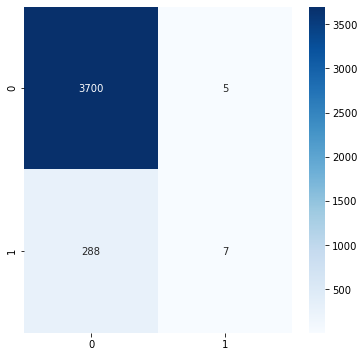

In [64]:
# log_reg=LogisticRegression(C=1000,max_iter=10000)
# log_reg.fit(X_train,y_train)
# y_pred = log_reg.predict(X_test)
# print('--------------------------------------------------------------------------')
# print('Logistic Regression:')
# print('Traning Model accruracy scores: {:.3f}'.format(log_reg.score(X_train,y_train)))
# print('Test Model accruracy scores: {:.3f}'.format(log_reg.score(X_test,y_test)))
# print('--------------------------------------------------------------------------')

c_m = confusion_matrix(y_test,preds)
c_m
# -> Prediction
# | Reality

plt.subplots(figsize=(6,6))
sns.heatmap(c_m, annot=True, cmap='Blues', fmt='g')
plt.show()

In [65]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
# Create the DMatrix from X and y: churn_dmatrix
churn_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                    nfold=3, num_boost_round=5, 
                    metrics="error", as_pandas=True, seed=123)

In [67]:
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                    nfold=3, num_boost_round=5, 
                    metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.662244       0.004893       0.648496      0.026861
1        0.718713       0.010947       0.684259      0.011271
2        0.720723       0.011824       0.686307      0.013923
3        0.739320       0.011062       0.697227      0.016340
4        0.746341       0.006290       0.703497      0.018706
0.703497


In [68]:
# train = pd.concat([train_df, train_set['churn']], axis=1)

In [69]:
# features = []
# features = train.columns.tolist()
# features.remove('churn')
# features.remove('cust_id')

# target = 'churn'

In [70]:
# # USING LOGISTIC REGRESSION TO FIT EACH FEATURE ONE BY ONE; WE CAN CALCULATE THE AUC ON EACH FEATURE FOR THE TRAINING DATA

# # Define the function score that will be used to assess the accuracy of each feature

# def score (dataSet: DataFrame, withModel: LogisticRegression, feature: str):
#     dataSet[f"p donation {feature}"] = DataFrame(withModel.predict_proba(dataSet[[feature]]))[1]

# # Define the function buildLogisticRegression that will be used to instanciate and train a logistic model

# def buildLogisticRegression (onDataSet: DataFrame, forVariable: str, target: str) -> LogisticRegression:
#     # 1.
#     logisticRegressionModel = LogisticRegression(solver = "lbfgs", max_iter = 500)
#     # 2.
#     logisticRegressionModel.fit(onDataSet[[forVariable]], onDataSet[target])
#     # 3. 
#     return logisticRegressionModel

# # Create two empty lists where the AUC's (for each feature in the feature list) of the training and test sets will be stored



In [109]:
# # CALCULATING THE AUC FOR EACH FEATURE ON TEH LOGISTIC REGRESSION MODEL. WE KEEP THE FEATURES THAT HAVE AUC ABOVE 0.55
# aucsTrain = []
# aucsTest  = []
# for feature in features:
#     mod = buildLogisticRegression(onDataSet = train, forVariable = feature, target = target)
#     score(dataSet =  train, withModel = mod, feature = feature)
#     score(dataSet =  train, withModel = mod, feature = feature)
    
#     aucsTrain.append(roc_auc_score(array(train[target]),array(train[f"p donation {feature}"])))
#     aucsTest.append(roc_auc_score(array(train[target]),array(train[f"p donation {feature}"])))

# aucs = {"features":features,"training":aucsTrain,"test":aucsTest}


# df_aucs = DataFrame(aucs).sort_values(by=["test"], ascending = False)
# df_aucs['to_keep'] = 1
# df_aucs.loc[df_aucs['test'] <= 0.5, 'to_keep'] = 0

# df_aucs

,features,training,test,to_keep
73,fl_Var126_is_missing,0.590365,0.590365,1
109,fe_Var217,0.579308,0.579308,1
106,fe_Var212,0.569238,0.569238,1
15,Var73,0.568702,0.568702,1
16,Var74,0.566537,0.566537,1
...,...,...,...,...
35,Var144,0.477551,0.477551,0
32,Var134,0.468587,0.468587,0
13,Var65,0.466242,0.466242,0
19,Var81,0.450676,0.450676,0


In [118]:
# df_aucs_2 = df_aucs[df_aucs['to_keep'] == 1]

In [123]:
# new_features = df_aucs_2['features'].tolist()

In [124]:
# df = train[new_features]

In [126]:
# df.columns

Index(['fl_Var126_is_missing', 'fe_Var217', 'fe_Var212', 'Var73', 'Var74',
       'fe_Var218', 'Var126', 'fe_Var199', 'fe_Var228', 'Var13',
       ...
       'fe_Var219', 'Var123', 'fl_Var51_is_missing', 'Var83', 'fe_Var204',
       'fe_Var196', 'Var149', 'fl_Var149_is_missing', 'fl_Var109_is_missing',
       'fl_Var24_is_missing'],
      dtype='object', length=103)

In [128]:
# y = train_set.churn
# y

0       0
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    1
9999    0
Name: churn, Length: 10000, dtype: int64

In [132]:
# # SPLITTING THE BASETABLE DATA INTO TRAIN AND TEST

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.5)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

(8000, 103) (8000,)
(2000, 103) (2000,)


In [71]:
# instanciate the models
logistic     = LogisticRegression(max_iter = 1000)
tree         = DecisionTreeClassifier()
randomForest = RandomForestClassifier(n_estimators = 700)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()
xgb_2        = XGBClassifier(Objective = 'binary:logistic',n_estimators=10, seed=123)

In [72]:
# create a dict to loop through the models later on
models = {"logistic"     :logistic,
          "tree"         :tree,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "neuralNet"    :neuralNet,
          "svm"         :svm,
          "xgb_2"       :xgb_2}

In [73]:
# fit the models
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")

logistic has been trained successfully
tree has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
neuralNet has been trained successfully
svm has been trained successfully
[09:36:14] WARNING: ..\src\learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:36:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb_2 has been trained successfully


In [74]:
# AUC

performances = {}

for model in models:
    predictions   = models[model].predict(X_test)
    probabilities = DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    auc           = roc_auc_score(array(y_test),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}
    
pd.DataFrame(performances)

,logistic,tree,randomForest,boostedTree,neuralNet,svm,xgb_2
Accuracy,0.925250,0.859000,0.926250,0.926500,0.918500,0.926250,0.926750
AUC,0.693385,0.537016,0.661974,0.699938,0.652406,0.648842,0.671066


In [ ]:
#parameter tuning

In [163]:
# model = GradientBoostingClassifier(random_state = 1)
# params = {
#     "learning_rate": [0.01],
#     "min_samples_split": [2,3,4],
#     "min_samples_leaf": [1,2,3],
#     "max_depth":[3],
#     "criterion": ["friedman_mse"],
#     "subsample":[0.5, 0.618, 0.8, 0.9, 0.95],
#     "n_estimators":[50, 100]
#    }
# params = {"n_estimators" : [100,350,400,450],
#          "max_depth" : [1,2,3,5,6],
#          "learning_rate" : [0.1, 0.05, 0.01],
#          "loss" : ['deviance', 'exponential'],
#          "subsample" : [0.5, 0.6, 0.8, 0.9, 0.95],
#          "criterion" : ["friedman_mse", "mse", "mae"],
#          "min_samples_split" : [1,2,3,4],
#          "min_samples_leaf" : [1,2,3]}

# gs = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc')

# gs.fit(X_train, y_train)

# print("Best AUC ROC : ", gs.best_score_)
# print("Best parameters : ", gs.best_params_)

KeyboardInterrupt: 

In [160]:
model = GradientBoostingClassifier(n_estimators = 400, max_depth = 3, learning_rate = 0.01, subsample = 0.618)
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=400,
                           subsample=0.618)

In [162]:
performances = {}


predictions   = model.predict(X_test)
probabilities = DataFrame(model.predict_proba(X_test))[1]
accuracy      = accuracy_score(y_test,predictions)
auc           = roc_auc_score(array(y_test),array(probabilities))
    
performances[model] = {"Accuracy":accuracy,"AUC":auc}
    
pd.DataFrame(performances)

([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomState(MT19937) at 0x2A368F3B440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n                      random_state=RandomSta

# Train and predict with XGB

In [366]:
trainingSet = train_df
testSet     = test_DT

In [367]:
trainingSet.head(2)

,cust_id,Var1,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,fe_Var219,fe_Var220,fe_Var221,fe_Var222,fe_Var223,fe_Var225,fe_Var226,fe_Var227,fe_Var228,fe_Var229
0,3.0,0.0,0.0,0.0,0.0,1351.0,7.0,0.0,0.0,0.0,...,0.8075,0.0874,0.1268,0.0874,0.7373,0.2221,0.0565,0.1230,0.0100,0.2008
1,4.0,0.0,0.0,0.0,0.0,644.0,0.0,0.0,0.0,0.0,...,0.8075,0.0027,0.7418,0.0027,0.7373,0.5206,0.0565,0.7034,0.6502,0.5670


In [368]:
testSet.head(2)

,cust_id,Var1,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,fe_Var219,fe_Var220,fe_Var221,fe_Var222,fe_Var223,fe_Var225,fe_Var226,fe_Var227,fe_Var228,fe_Var229
0,1.0,0.0,0.0,0.0,0.0,224.0,0.0,0.0,0.0,0.0,...,0.803,0.0011,0.7377,0.0011,0.7257,0.5229,0.0289,0.703,0.6489,0.5732
1,2.0,0.0,0.0,0.0,0.0,7511.0,7.0,0.0,0.0,0.0,...,0.803,0.0002,0.7377,0.0002,0.7257,0.2082,0.1612,0.703,0.0892,0.1940


In [369]:
type(churn)

pandas.core.series.Series

#### 1. Instanciate the model

In [370]:
model = xg_cl

#### 2. Set the list of features and target

In [371]:
features = []

for column in trainingSet.columns:
    if column not in ("cust_id","churn","fl_cust_id_is_missing","fl_churn_is_missing"):
        features.append(column)
        
target   = churn

In [372]:
features

['Var1',
 'Var3',
 'Var4',
 'Var5',
 'Var6',
 'Var7',
 'Var9',
 'Var10',
 'Var11',
 'Var12',
 'Var13',
 'Var14',
 'Var16',
 'Var17',
 'Var18',
 'Var19',
 'Var21',
 'Var22',
 'Var23',
 'Var24',
 'Var25',
 'Var26',
 'Var27',
 'Var28',
 'Var30',
 'Var33',
 'Var34',
 'Var35',
 'Var36',
 'Var37',
 'Var38',
 'Var40',
 'Var41',
 'Var43',
 'Var44',
 'Var45',
 'Var46',
 'Var47',
 'Var49',
 'Var50',
 'Var51',
 'Var53',
 'Var54',
 'Var56',
 'Var57',
 'Var58',
 'Var59',
 'Var60',
 'Var61',
 'Var62',
 'Var63',
 'Var64',
 'Var65',
 'Var66',
 'Var68',
 'Var69',
 'Var70',
 'Var71',
 'Var72',
 'Var73',
 'Var74',
 'Var75',
 'Var76',
 'Var77',
 'Var78',
 'Var80',
 'Var81',
 'Var82',
 'Var83',
 'Var84',
 'Var85',
 'Var86',
 'Var87',
 'Var88',
 'Var89',
 'Var91',
 'Var92',
 'Var93',
 'Var94',
 'Var95',
 'Var96',
 'Var97',
 'Var98',
 'Var99',
 'Var100',
 'Var101',
 'Var102',
 'Var103',
 'Var104',
 'Var105',
 'Var106',
 'Var107',
 'Var108',
 'Var109',
 'Var110',
 'Var111',
 'Var112',
 'Var113',
 'Var114',
 '

In [373]:
trainingFeatures = trainingSet[features]
trainingTarget = target

In [374]:
print(type(trainingFeatures))
print(type(trainingTarget))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


####  3. Fit the model

In [375]:
model.fit(trainingFeatures,trainingTarget)

[20:39:42] WARNING: ..\src\learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:39:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(Objective='binary:logistic', base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=8,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=123, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### 4. Add probabilities to the dataSets

In [376]:
trainingSet["proba churn"] = DataFrame(model.predict_proba(trainingSet[features]))[1]
testSet["proba churn"]     = DataFrame(model.predict_proba(testSet[features]))[1]

In [377]:
DataFrame(model.predict_proba(testSet[features]))[1]

0       0.135306
1       0.133321
2       0.155801
3       0.190035
4       0.236245
          ...   
9995    0.106020
9996    0.027449
9997    0.221979
9998    0.058776
9999    0.051116
Name: 1, Length: 10000, dtype: float32

In [378]:
export = testSet["proba churn"]

In [379]:
export.to_csv(r'C:\Users\feledu1\Desktop\S2\Statistical and Machine Learning Approach for Marketing\Kaggle\Favour_Predictions_2.csv', index = False)

In [ ]:
# for model in models:
#     models[model].fit(trainingSet[features],trainingSet[target])
#     print(f"{model} has been trained successfully")

################################################## NEW PHASE ##################################################